In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ReLU, ELU, Softmax
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils import clip_grad_norm_
import random
import matplotlib.ticker as ticker
from my_sol_new_RNN_helper import *
%matplotlib inline

In [2]:
class graph_RNN_first_ed(nn.Module):
    def __init__(self, input_size, output_size, depth, description_node = False):
        super(graph_RNN_first_ed, self).__init__()
        
        self.output_size = output_size
        self.depth = depth
        self.d_n = description_node
        
        self.prep = nn.Linear(input_size, output_size)
        self.conv = nn.Linear(output_size + input_size, output_size) if self.\
                                            d_n else nn.Linear(output_size, output_size)

    def forward(self, nodes, matrix):
        output = self.prep(nodes)
        
        for _ in range(self.depth):
            output = torch.cat((output, nodes), 1) if self.d_n else output
            output = torch.mm(matrix, output)
            output = self.conv(output)
            output = torch.sigmoid(output)
            
        return output

In [113]:
class graph_RNN_second_ed(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth, description_node = False):
        super(graph_RNN_second_ed, self).__init__()
        
        self.output_size = output_size
        self.depth = depth
        self.d_n = description_node
        
        self.prep = nn.Linear(input_size, output_size)
        self.conv_other = nn.Linear(output_size + input_size, output_size - hidden_size) if self.\
                                            d_n else nn.Linear(output_size, output_size - hidden_size)
        self.conv_this = nn.Linear(output_size + input_size, hidden_size) if self.\
                                            d_n else nn.Linear(output_size, hidden_size)
        
        self.ReLU = nn.ReLU()

    def forward(self, nodes, neighbors):
        output = self.prep(nodes)
        
        for _ in range(self.depth):
            output = torch.cat((output, nodes), 1) if self.d_n else output
            nei = self.ReLU(self.conv_other(output))
            
            neighbors_tensor = None
            for i in neighbors:
                if neighbors_tensor is None:
                    neighbors_tensor = nei[i].mean(0)
                else:
                    neighbors_tensor = torch.cat([neighbors_tensor, nei[i].mean(0)], 0)
            neighbors_tensor = neighbors_tensor.reshape_as(nei)
            
            
            output = torch.cat((self.conv_this(output), neighbors_tensor), 1)
            output = self.ReLU(output)
            
        return output

In [4]:
class graph2vec(nn.Module):
    
    def __init__(self, n_categories, depth, num_eigenvectors, rnn_hidden, net_hidden, num_features = 4, 
                 num_classes = 10, center_eigenvectors = True, description_node = False, abs_eigenvectors = True):
        super(graph2vec, self).__init__()
#         self.rnn = graph_RNN_first_ed(num_features, n_categories, depth, description_node = description_node)
        self.rnn = graph_RNN_second_ed(num_features, rnn_hidden, n_categories, depth, description_node = description_node)
        self.num_eigenvectors = num_eigenvectors
        self.net = FCNet(n_categories * num_eigenvectors, net_hidden, num_classes)
        self.center_eigenvectors = center_eigenvectors
        self.abs_eigenvectors = abs_eigenvectors
        
    def forward(self, nodes, neighbors):
        output = self.rnn.forward(nodes, neighbors)
        
        n = PCA_svd(output, g2v.num_eigenvectors, center=self.center_eigenvectors)#['components']
        if self.abs_eigenvectors:
            com, expv = n['components'], n['explained_variance']
            n = torch.mul(expv, com.t()).t()
        else:
            n = n['components']
        out = self.net.forward(n.reshape((1, -1)).float())
        return out
    
    def test(self, nodes, matrix):
        with torch.no_grad():
            output = self.rnn.forward(nodes, matrix)

            n = PCA_svd(output, g2v.num_eigenvectors, center=self.center_eigenvectors)#['components']
            if self.abs_eigenvectors:
                com, expv = n['components'], n['explained_variance']
                n = torch.mul(expv, com.t()).t()
            else:
                n = n['components']
            out = self.net.forward(n.reshape((1, -1)).float())
        return out

In [78]:
class graph2vec_next(nn.Module):
    
    def __init__(self, rnn, n_categories, num_classes = 10):
        super(graph2vec_next, self).__init__()
        self.rnn = rnn
        self.without_PCA_linear = nn.Linear(n_categories, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, nodes, matrix):
        output = self.rnn.forward(nodes, matrix)
        
        x = torch.mm(output.type_as(self.PCA_substitute), self.PCA_substitute).mean(0)
        x = self.without_PCA_linear(x.float()).reshape((-1, 10))
        return self.softmax(x)
    
    def test(self, nodes, matrix):
        with torch.no_grad():
            output = self.rnn.forward(nodes, matrix)

            x = torch.mm(output.type_as(self.PCA_substitute), self.PCA_substitute).mean(0)
            x = self.without_PCA_linear(x.float()).reshape((-1, 10))
            out = self.softmax(x)
        return out

In [6]:
def get_eigenvectors(model, train_dataset, n_categories, counter):
    evg_vectors = [torch.zeros((model.num_eigenvectors, n_categories), 
                                       dtype=torch.float64)] * 10
    with torch.no_grad():
        for indx in range(len(train_dataset)):
            node, matrix, clas = train_dataset.__getitem__(indx)
            if len(node) <= 5:
                continue
                
            output = self.rnn.forward(nodes, matrix)

            n = PCA_svd(output, model.num_eigenvectors, center=True)#['components']
            com, expv = n['components'], n['explained_variance']
            n = torch.mul(expv, com.t()).t()
            
            evg_vectors[l] = evg_vectors[l] + n
        for i, coun in enumerate(counter):
            evg_vectors[i] = evg_vectors[i] / coun
    
    PCA_substitute = torch.cat(evg_vectors, 0)
    PCA_substitute.requires_grad_(requires_grad = False)
    return PCA_substitute

In [7]:
train_dataset = GraphEmbDataset(graph_file='graph2vec/data/train_graphs')

## Распределение по классам

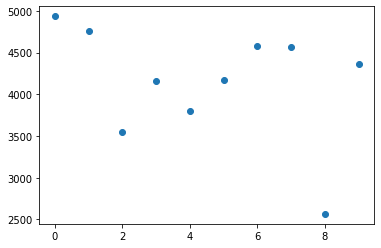

In [30]:
counter = np.zeros(10)
for i in range(len(train_dataset)):
    out_1 = train_dataset.__getitem__(i)
    if len(out_1[0]) > 5:
        counter[out_1[2]] +=1

plt.scatter(y = counter, x = np.arange(10))

In [40]:
batch_size = 64
num_neighbors = 3
n_categories = 30
num_eigenvectors = 3
net_hidden = 20
rnn_hidden = 10
# grads = [[]] * 8

##  центрир_векоторов, нет  домнож на СЧ, нет транспонирование

In [117]:
g2v = graph2vec(n_categories, num_neighbors, num_eigenvectors, 
                rnn_hidden, net_hidden, center_eigenvectors=True, description_node = True, abs_eigenvectors = False)

In [118]:
g2v.rnn = g2v_next.rnn

In [119]:
loss = nn.CrossEntropyLoss(weight=Tensor(counter / counter.sum()))
optimizer = optim.Adagrad(g2v.parameters(), lr=0.2)

losses = train(g2v, train_dataset, batch_size, 1, optimizer, loss)

plt.scatter(range(len(losses[10:])), losses[10:])

1 from 1:   0%|          | 0/42743 [00:00<?, ?it/s]


RuntimeError: svd_cpu: the updating process of SBDSDC did not converge (error: 15)

In [106]:
g2v_next = graph2vec_next(g2v.rnn, n_categories)

# PCA_substitute = get_eigenvectors(g2v, train_dataset, n_categories, counter)
g2v_next.PCA_substitute = torch.eye(30)#torch.inverse(PCA_substitute) / 1000

optimizer = optim.Adagrad(g2v_next.parameters(), lr=0.4)
losses = train(g2v_next, train_dataset, batch_size, 1, optimizer, loss)

1 from 1: 42752it [05:31, 128.95it/s]                           


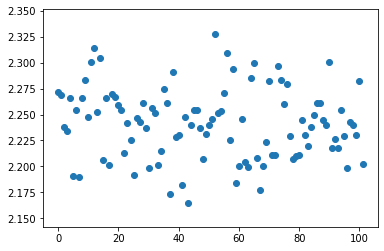

In [108]:
plt.scatter(range(len(losses[10:])), losses[10:])

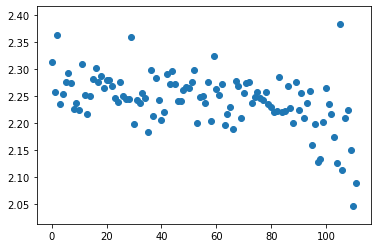

In [104]:
plt.scatter(range(len(losses)), losses)

In [109]:
showHeatMap(g2v_next, train_dataset)

TypeError: showHeatMap() takes 1 positional argument but 2 were given

## save & load